In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from src import RBFInterpolator
import numpy as np
import numpy.typing as npt
from typing import Tuple, Optional, List
from time import perf_counter

PROCESSED = Path('Processed', 'all')
LANDMASK_PATH = Path("landmask_01d.nc")
START_DATE = 5
DATE_INTERVAL = 3
FILES = [Path(f'2005_10_{i}.nc') for i in range(START_DATE, START_DATE + DATE_INTERVAL)]
FIGSIZE = (10, 3)
CMAP = 'jet'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and display data

In [3]:
LANDMASK = xr.open_dataset(LANDMASK_PATH)
datasets = [xr.open_dataset(PROCESSED / file) for file in FILES]
dataset = xr.concat(datasets, dim=list(datasets[0].dims)[0])

In [4]:
lat = dataset.lat.data
lon = dataset.lon.data
data = dataset.sla.data

# Plotting
vmin = data.min()
vmax = data.max()

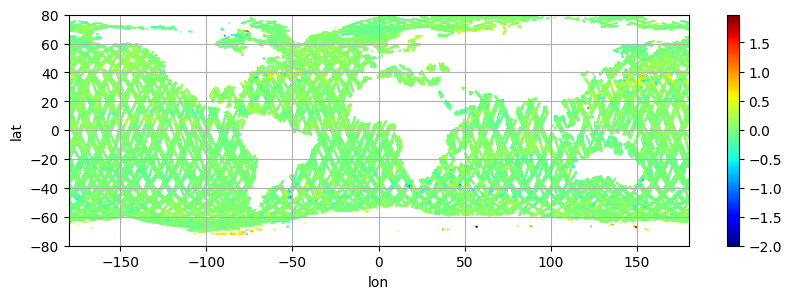

In [5]:
plt.figure(figsize=FIGSIZE)
plt.scatter(lon, lat, c=data, s=0.1, cmap=CMAP, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.grid()
plt.ylim([-80, 80])
plt.xlim([-180, 180])
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

# Grid data

In [6]:
def sign_add(x: float, y: float) -> float:
    """Adds y to x if x<=0 else it subtracts y from x"""
    return x + (y if x <= 0 else -y)
def create_grid(x_deg: float, y_deg: float, x_boundary: Tuple[float, float], y_boundary: Tuple[float, float]) -> List[npt.NDArray[np.float64]]:
    """Creates a grid of x, y"""
    x_start = sign_add(x_boundary[0], x_deg/2)
    x_end = sign_add(x_boundary[1], -x_deg/2)
    x: npt.NDArray[np.float64] = np.arange(x_start, x_end, x_deg)
    y_start = sign_add(y_boundary[0], y_deg/2)
    y_end = sign_add(y_boundary[1], -y_deg/2)
    y: npt.NDArray[np.float64] = np.arange(y_start, y_end, y_deg)
    return np.meshgrid(x, y)

def _landmask_coord_bool(landmask: xr.DataArray | npt.NDArray[np.float64], value: float) -> int:
    """Masks the landmask coordinate by value"""
    bool_arr =  np.where(landmask > value)[0]
    if len(bool_arr) == 0:
        if landmask[0] > value:
            return 0
        return len(landmask)
    return bool_arr[0]

def subset_landmask(landmask: xr.Dataset, x_boundary: Tuple[float, float], y_boundary: Tuple[float, float]) -> xr.Dataset:
    """ Takes a subset of the landmask based on the x and y boundaries"""
    lat_min = _landmask_coord_bool(landmask.lat, y_boundary[0])
    lat_max = _landmask_coord_bool(landmask.lat, y_boundary[1])
    lon_min = _landmask_coord_bool(landmask.lon, x_boundary[0])
    lon_max = _landmask_coord_bool(landmask.lon, x_boundary[1])
    return landmask.isel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max))

In [7]:
def plot_grid(
    x_grid: npt.NDArray[np.float64],
    y_grid: npt.NDArray[np.float64],
    grid: npt.NDArray[np.float64],
    landmask: Optional[npt.NDArray[np.float64]] = None,
    lon_boundary: Optional[Tuple[float, float]] = None,
    lat_boundary: Optional[Tuple[float, float]] = None,
    points_lon: Optional[npt.NDArray[np.float64]] = None,
    points_lat: Optional[npt.NDArray[np.float64]] = None,
    figsize: Tuple[float, float] = (10, 3),
    cmap: str = "jet",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    blocking: bool = True,
    title: Optional[str] = None
) -> None:
    # Input handling
    if lon_boundary is None:
        lon_boundary = (x_grid[0,:].min(), x_grid[0,:].max())
    if lat_boundary is None:
        lat_boundary = (y_grid[:,0].min(), y_grid[:,0].max())

    # Get lat, lon boundary indexes
    lat_idx = [_landmask_coord_bool(y_grid[:,0], lb) for lb in lat_boundary]
    lon_idx = [_landmask_coord_bool(x_grid[0,:], lb) for lb in lon_boundary]

    # Landmask
    if landmask is None:
        land_masked_grid = grid
    else:
        land_masked_grid = grid * landmask
    land_masked_grid = land_masked_grid[lat_idx[0] - 1:lat_idx[1], lon_idx[0] - 1:lon_idx[1]]

    # Extent of the grid
    extent = [*lon_boundary, *lat_boundary]

    # Valid points in the choosen boundary
    points_in_zone: npt.NDArray[np.bool_] | None = None
    if points_lon is not None and points_lat is not None:
        points_in_zone = (
            (points_lon >= extent[0])
            & (points_lon <= extent[1])
            & (points_lat >= extent[2])
            & (points_lat <= extent[3])
        )
    

    c_vmin = np.nanmin(land_masked_grid) if vmin is None else vmin
    c_vmax = np.nanmax(land_masked_grid) if vmax is None else vmax

    # Plot
    fig = plt.figure(figsize=figsize)
    plt.imshow(land_masked_grid, extent=extent, origin='lower', vmin=c_vmin, vmax=c_vmax, cmap=cmap)
    plt.colorbar()
    if points_lon is not None and points_lat is not None and points_in_zone is not None:
        plt.scatter(points_lon[points_in_zone], points_lat[points_in_zone], s=1, color=(0,0,0,0.01))
    plt.xlim(lon_boundary)
    plt.ylim(lat_boundary)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    if title is not None:
        plt.title(title)
    #plt.show(block=blocking)

In [8]:
X_RESOLUTION = 1
Y_RESOLUTION = 1
X_BOUNDARY = (-180, 180)
Y_BOUNDARY = (-70, 70)

# Construct grid
x_grid, y_grid = create_grid(X_RESOLUTION, Y_RESOLUTION, X_BOUNDARY, Y_BOUNDARY)
grid_lonlat = np.vstack([x_grid.flatten(), y_grid.flatten()]).T

# Save lon, lat in one matrix
lonlat = np.vstack([lon, lat]).T

# Land mask within the same size as the grid
landmask_grid = subset_landmask(LANDMASK, X_BOUNDARY, Y_BOUNDARY)

## Interpolation methods

### RBF

In [9]:
ocean_mask = ~np.isnan(landmask_grid.z.data)
ocean_mask_flat = ocean_mask.flatten()
interp_y = np.empty(ocean_mask.shape, dtype=np.float64)
interp_y.fill(np.nan)

In [10]:
kernel = "linear"
neighbors = 100
max_distance = 500 #km
min_points = 2
start = perf_counter()
interp_func = RBFInterpolator(
    lonlat,
    data,
    neighbors=neighbors,
    kernel=kernel,
    max_distance=max_distance,
    min_points=min_points,
    lon_column=0,
    lat_column=1
)
interp_y[ocean_mask] = interp_func(grid_lonlat[ocean_mask_flat])
print(f"kernel = {kernel}, neighbors = {neighbors}, max_distance = {max_distance}km: {(perf_counter() - start)/60:.2f}min") 

kernel = linear, neighbors = 100, max_distance = 500km: 1.52min


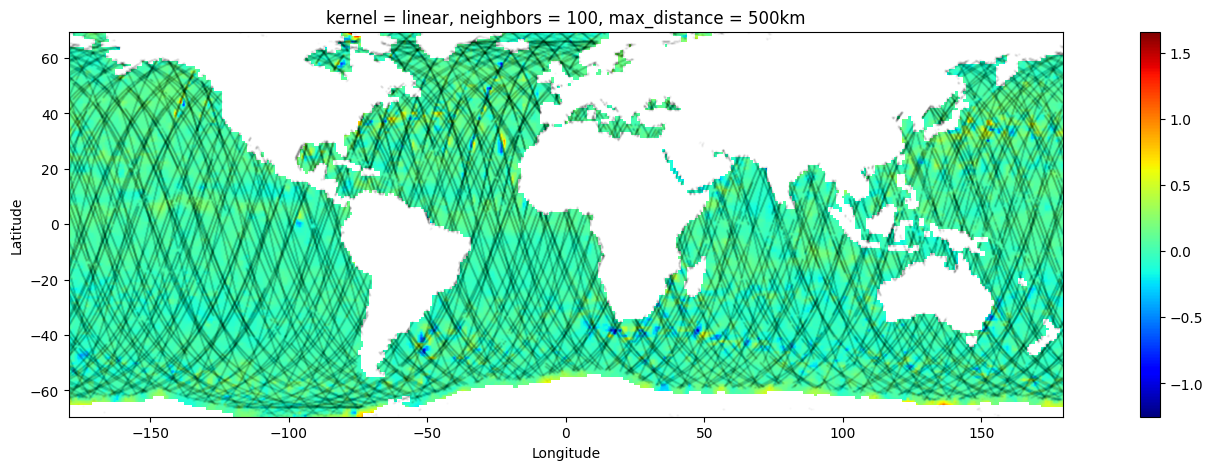

In [12]:
plot_grid(x_grid=x_grid, y_grid=y_grid, grid=interp_y, landmask=landmask_grid.z.data, points_lon=lon, points_lat=lat, figsize=(20,5), cmap=CMAP, title=f"kernel = {kernel}, neighbors = {neighbors}, max_distance = {max_distance}km")
plt.show()